# Method
The main structure are generally similar to HW2.

Here's some modification:
1. Use `torch.autograd.grad()` to compute the derivative with respect to input x
2. Define a new loss function = $MSE_{function} + MSE_{derivative}$.
3. Epoch 4000 -> 2000

Target: Approximated both $f(x) = \frac{1}{1+25x^2}$ and its derivative $f'(x) = \frac{-50x}{(1+25x^2)^2}$



In [33]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def runge_function(x):
    return 1.0 / (1.0 + 25.0 * x**2)

def runge_derivative(x):
    return -50.0 * x / (1.0 + 25.0 * x**2)**2

# ---------- Data ----------
# Make inputs require grad so we can compute dy/dx via autograd
x_train = torch.linspace(-1, 1, 800).view(-1, 1).requires_grad_(True)
y_train = runge_function(x_train).detach()  # targets don't need grad

x_val = torch.linspace(-0.95, 0.95, 100).view(-1, 1).requires_grad_(True)
y_val = runge_function(x_val).detach()

x_test = torch.linspace(-1, 1, 100).view(-1, 1).requires_grad_(True)
y_test = runge_function(x_test).detach()

# true derivatives (targets)
y_train_d = runge_derivative(x_train).detach()
y_val_d = runge_derivative(x_val).detach()
y_test_d = runge_derivative(x_test).detach()

# ---------- Model ----------
class RungeNet(nn.Module):
    def __init__(self):
        super(RungeNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.network(x)

model = RungeNet()

# ---------- Training setup ----------
learning_rate = 0.001
epochs = 2000
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
train_f_losses = []
train_d_losses = []
val_losses = []
val_f_losses = []
val_d_losses = []

print("\nStart training...")
for epoch in range(epochs):
    model.train()
    # forward for function
    y_pred = model(x_train)                         # shape (N,1)
    # compute derivative dy/dx using autograd; create_graph=True so backward flows to params
    dy_dx = torch.autograd.grad(
        outputs=y_pred,
        inputs=x_train,
        grad_outputs=torch.ones_like(y_pred),
        create_graph=True,
        retain_graph=True
    )[0]

    f_loss = criterion(y_pred, y_train)
    d_loss = criterion(dy_dx, y_train_d)
    loss = f_loss + d_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        y_val_pred = model(x_val)
    y_val_pred_for_grad = model(x_val)  
    dy_dx_val = torch.autograd.grad(
        outputs=y_val_pred_for_grad,
        inputs=x_val,
        grad_outputs=torch.ones_like(y_val_pred_for_grad),
        create_graph=False,
        retain_graph=False
    )[0]

    val_f_loss = criterion(y_val_pred_for_grad, y_val)
    val_d_loss = criterion(dy_dx_val, y_val_d)
    val_loss = val_f_loss +  val_d_loss

    # record losses
    train_losses.append(loss.item())
    train_f_losses.append(f_loss.item())
    train_d_losses.append(d_loss.item())

    val_losses.append(val_loss.item())
    val_f_losses.append(val_f_loss.item())
    val_d_losses.append(val_d_loss.item())

    if (epoch + 1) % 200 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Train loss: {loss.item():.6e}, Val loss: {val_loss.item():.6e} '
              f'(f: {f_loss.item():.6e}, d: {d_loss.item():.6e})')

print("Training complete.\n")



Start training...
Epoch [200/2000], Train loss: 2.112114e-02, Val loss: 2.174537e-02 (f: 1.344131e-05, d: 2.110770e-02)
Epoch [400/2000], Train loss: 1.497718e-02, Val loss: 1.618701e-02 (f: 7.921813e-06, d: 1.496926e-02)
Epoch [600/2000], Train loss: 1.266244e-02, Val loss: 1.229170e-02 (f: 6.692759e-06, d: 1.265574e-02)
Epoch [800/2000], Train loss: 1.422312e-02, Val loss: 1.615538e-02 (f: 6.550400e-06, d: 1.421657e-02)
Epoch [1000/2000], Train loss: 1.948879e-02, Val loss: 1.994702e-02 (f: 1.252315e-05, d: 1.947626e-02)
Epoch [1200/2000], Train loss: 2.077009e-02, Val loss: 2.017112e-02 (f: 1.383828e-05, d: 2.075625e-02)
Epoch [1400/2000], Train loss: 2.188847e-02, Val loss: 2.031976e-02 (f: 1.572160e-05, d: 2.187275e-02)
Epoch [1600/2000], Train loss: 2.503940e-02, Val loss: 2.790270e-02 (f: 1.823729e-05, d: 2.502117e-02)
Epoch [1800/2000], Train loss: 2.977191e-02, Val loss: 2.809720e-02 (f: 2.487366e-05, d: 2.974703e-02)
Epoch [2000/2000], Train loss: 3.443019e-02, Val loss: 2.8

In [34]:

# ---------- Evaluation on test ----------
model.eval()
# compute function prediction
y_pred_test = model(x_test).detach()
# compute derivative prediction (we need gradients w.r.t. x_test)
y_pred_test_for_grad = model(x_test)
dy_dx_test = torch.autograd.grad(
    outputs=y_pred_test_for_grad,
    inputs=x_test,
    grad_outputs=torch.ones_like(y_pred_test_for_grad),
    create_graph=False
)[0].detach()

# Errors for function and derivative
mse_f = criterion(y_pred_test, y_test).item()
max_err_f = torch.max(torch.abs(y_pred_test - y_test)).item()

mse_d = criterion(dy_dx_test, y_test_d).item()
max_err_d = torch.max(torch.abs(dy_dx_test - y_test_d)).item()

print(f"Function test - MSE: {mse_f:.8e}, Max abs err: {max_err_f:.8e}")
print(f"Derivative test - MSE: {mse_d:.8e}, Max abs err: {max_err_d:.8e}")


Function test - MSE: 2.93828380e-05, Max abs err: 2.18735337e-02
Derivative test - MSE: 3.77460420e-02, Max abs err: 9.46605921e-01


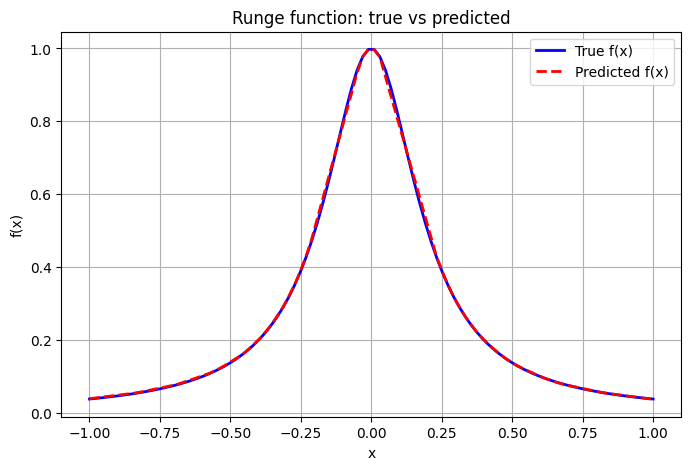

In [35]:

# ---------- Plots ----------
# 1) true function vs predicted
plt.figure(figsize=(8,5))
plt.plot(x_test.detach().numpy(), y_test.detach().numpy(), 'b-', label='True f(x)', linewidth=2)
plt.plot(x_test.detach().numpy(), y_pred_test.numpy(), 'r--', label='Predicted f(x)', linewidth=2)
plt.xlabel('x'); plt.ylabel('f(x)'); plt.legend(); plt.grid(True)
plt.title('Runge function: true vs predicted')
plt.show()


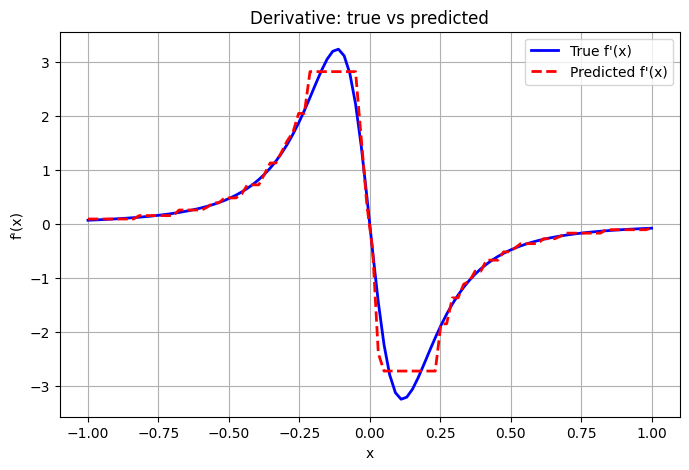

In [36]:

# 2) true derivative vs predicted derivative
plt.figure(figsize=(8,5))
plt.plot(x_test.detach().numpy(), y_test_d.detach().numpy(), 'b-', label="True f'(x)", linewidth=2)
plt.plot(x_test.detach().numpy(), dy_dx_test.numpy(), 'r--', label="Predicted f'(x)", linewidth=2)
plt.xlabel('x'); plt.ylabel("f'(x)"); plt.legend(); plt.grid(True)
plt.title("Derivative: true vs predicted")
plt.show()


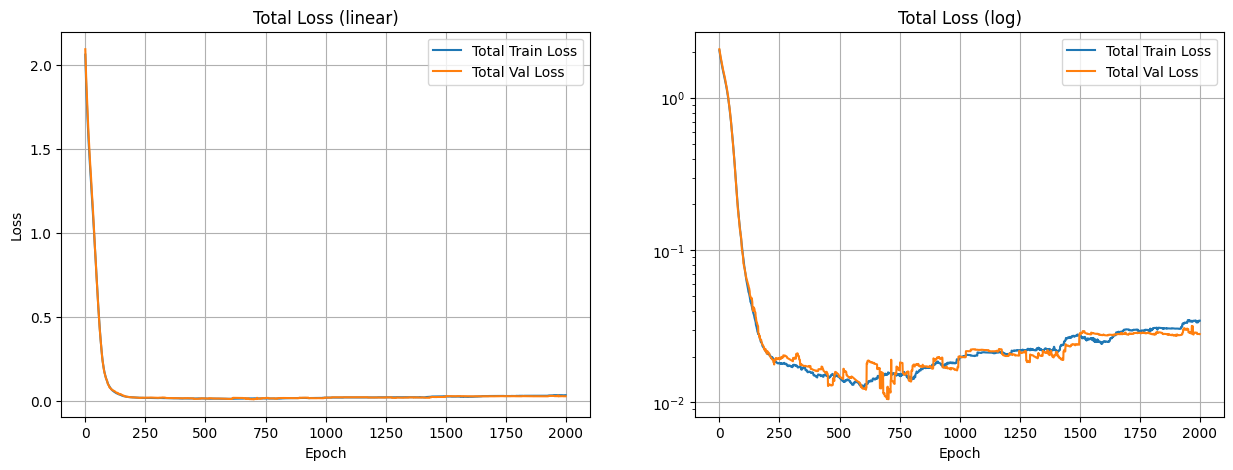

In [37]:

# 3) Loss curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(train_losses, label='Total Train Loss')
axes[0].plot(val_losses, label='Total Val Loss')
axes[0].set_title('Total Loss (linear)')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss'); axes[0].legend(); axes[0].grid(True)

axes[1].plot(train_losses, label='Total Train Loss')
axes[1].plot(val_losses, label='Total Val Loss')
axes[1].set_yscale('log'); axes[1].set_title('Total Loss (log)')
axes[1].set_xlabel('Epoch'); axes[1].legend(); axes[1].grid(True)
plt.show()


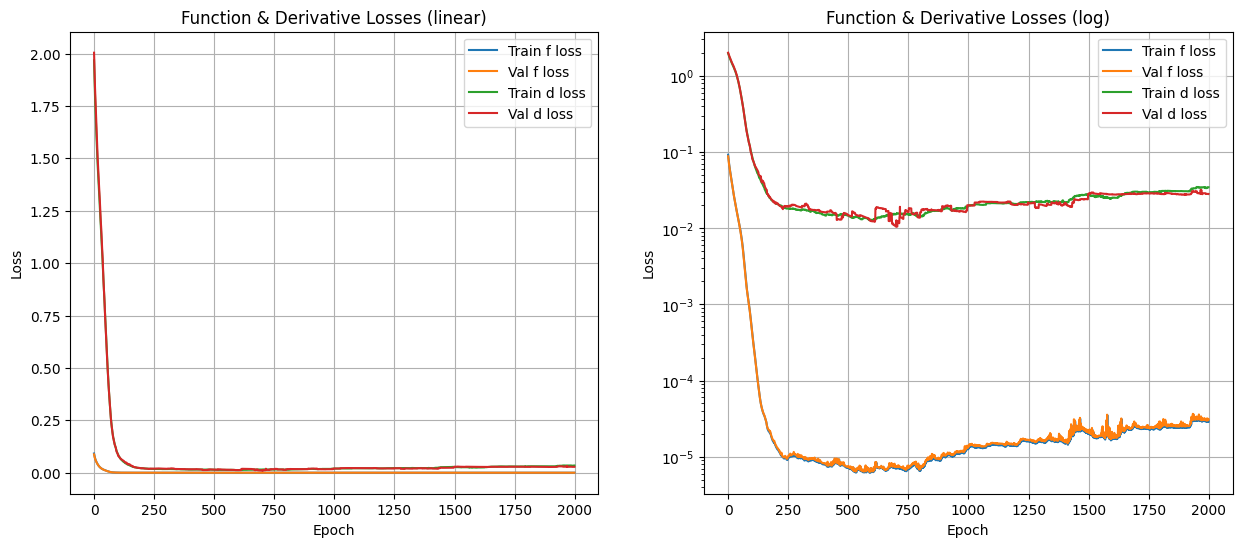

In [38]:

# 4) Separate function & derivative losses (linear)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(train_f_losses, label='Train f loss')
axes[0].plot(val_f_losses, label='Val f loss')
axes[0].plot(train_d_losses, label='Train d loss')
axes[0].plot(val_d_losses, label='Val d loss')
axes[0].set_title('Function & Derivative Losses (linear)')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss'); axes[0].legend(); axes[0].grid(True)

axes[1].plot(train_f_losses, label='Train f loss')
axes[1].plot(val_f_losses, label='Val f loss')
axes[1].plot(train_d_losses, label='Train d loss')
axes[1].plot(val_d_losses, label='Val d loss')
axes[1].set_yscale('log'); axes[1].set_title('Function & Derivative Losses (log)')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Loss'); axes[1].legend(); axes[1].grid(True)

plt.show()